IA & Data science (3i026) -- 2018-2019
--------
*&copy; Equipe pédagogique: Manon Ansart, Vincent Guigue, Marie-Jeanne Lesot, Christophe Marsala, Olivier Schwander.*

# TD-TME06: méthodes d'ensembles

L'objectif de ce TP est d'implémenter des méthodes d'ensembles et de les évaluer. Dans un premier temps, on se focalisera sur l'algorithme de bagging appliqué aux arbres de décision, puis on passera au random forests.

Comme précédemment, on ne considére que le cas où les attributs sont tous numériques.

<font size="+1">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

CARNIELLI Ariana

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>tme-06</tt> et rajouter à la suite de <tt>tme-06</tt> les noms des membres du binômes séparés par un tiret.

Charger la librairie <code>iads</code> pour avoir accès aux fonctions déjà écrites.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import graphviz as gv
%matplotlib inline  

# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')

# Importation de la librairie iads
import iads as iads

# importation de LabeledSet
from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

Pour tester les fonctions à implémenter dans cette séance, on utilise la base d'exemples suivante :

In [2]:
# Base d'exemples pour tester les fonctions:
set_exemples = ls.LabeledSet(2)
set_exemples.addExample([2.10492662303,1.10648470933],1)
set_exemples.addExample([0.297525816499,-0.662504551625],1)
set_exemples.addExample([1.6694258992,0.313687975072],1)
set_exemples.addExample([1.20583098523,3.50817309097],1)
set_exemples.addExample([1.13739407316,1.96688273992],1)
set_exemples.addExample([2.32319808376,0.536577798714],1)
set_exemples.addExample([-0.953004346997,0.596926923927],1)
set_exemples.addExample([1.00574784804,-0.0959606771199],1)
set_exemples.addExample([0.747509778063,0.429544908608],1)
set_exemples.addExample([1.39048336283,0.442578873406],1)
set_exemples.addExample([0.0470799329584,-1.97596265858],-1)
set_exemples.addExample([-0.673998013071,0.0693931940855],-1)
set_exemples.addExample([-0.84587451642,0.761766191612],-1)
set_exemples.addExample([-1.39596839858,-0.943807082082],-1)
set_exemples.addExample([0.319301767707,0.566169775123],-1)
set_exemples.addExample([1.43459714786,0.935712030926],-1)
set_exemples.addExample([-1.69323475458,-1.89563184035],-1)
set_exemples.addExample([0.81167008598,-1.17927660655],-1)
set_exemples.addExample([-1.03264043689,-1.08118488864],-1)
set_exemples.addExample([0.609517439986,-2.88593327349],-1)

## Etape 1: retours sur la séance 5


<font color="RED" size="+1">**[Q]**</font> Modifier la fonction <code>shannon()</code> afin qu'elle puisse s'appliquer sur une liste vide ou sur une liste à un seul élément: dans ce cas-là, la fonction rend $0.0$.

In [3]:
def shannon(P):
    if len(P) <= 1:
        return 0.0
    entropie = 0
    taille = len(P)
    for pi in P:
        if pi != 0:
            #print(pi)
            entropie = entropie - (pi * math.log(pi, taille))
    return entropie

In [4]:
# Exemples d'utilisation:
print("P=[]  : ", shannon([]))
print("P=[1] : ", shannon([1]))

P=[]  :  0.0
P=[1] :  0.0


Recopier les fonctions suivantes à partir de votre notebook du TD-TME05.
- classe_majoritaire(LSet)
- entropie(LSet)
- discretise(LSet, col)
- divise(LSet,att,seuil)
- construit_AD(LSet,epsilon)

ainsi que les classes:
- class ArbreBinaire
- class ArbreDecision

Remplissez la boite suivante en recopiant toutes ces fonctions et classes du TD_TME05.

In [5]:
def discretise2(LSet, col):
    # Extraction de la colonne qui nous intéresse de x
    # et transformation de y en un tableau 1D.
    x = LSet.x[:, col]
    y = LSet.y[:, 0]
    
    # Tri de x par valeurs croissantes et tri correspondant dans y.
    ind = np.argsort(x)
    x = x[ind]
    y = y[ind]
    
    # Sélection des indices où y change entre -1 et 1
    indices = np.where(y[:-1] != y[1:])[0]
    
    # Calcul des seuils correspondants
    seuil = (x[indices] + x[indices+1])/2
    
    # Tableau pour garder l'entropie
    entropie = np.zeros(seuil.size)
    for i in range(seuil.size):
        # Ici, on pourrait définir
        # j = indices[i]
        # séparer le tableau y entre y[:(j+1)] et y[(j+1):],
        # calculer l'entropie des deux sous-tableaux et ensuite l'entropie
        # moyenne. Cependant, cela ne marche pas dans un cas :
        # si x[j] == x[j+1], alors ce seuil n'est pas un vrai seuil, on ne
        # peut pas séparer x[j] de x[j+1] par une inégalité.
        # Pour cela, on choisit de re-faire la séparation en comparant x à
        # seuil[i]. On risque ainsi que l'un de nos tableaux soit vide,
        # il faut en tenir compte.
        s = seuil[i]
        yGauche = y[x <= s]
        yDroite = y[x > s]
        
        # Calcul de l'entropie du sous-tableau gauche. Vaut 0 si vide.
        if yGauche.size == 0:
            entGauche = 0.0
        else:
            p = (yGauche==1).sum()/yGauche.size
            entGauche = shannon([p, 1 - p])
            
        # Calcul de l'entropie du sous-tableau droit. Vaut 0 si vide.
        if yDroite.size == 0:
            entDroite = 0.0
        else:
            p = (yDroite==1).sum()/yDroite.size
            entDroite = shannon([p, 1 - p])
            
        entropie[i] = (entGauche*yGauche.size + entDroite*yDroite.size)/y.size
        
    # À la fin, on prend la valeur minimale de l'entropie.
    imin = np.argmin(entropie)
    return (seuil[imin], entropie[imin])

On a codé à nouveau la fonction `discretise` car la version originelle avait un problème qui provoquait une boucle infinie dans la construction de l'arbre et dépassait la capacité maximale de recursion de Python. En effet, dans le dataset de test utilisé à la fin de ce TME, certaines colonnes ont des valeurs répétées (ce qui arrive avec probabilité zéro dans le cas des datasets gaussiens aléatoires) qui sont classées dans des classes séparées. Dans ce cas, l'appel de la fonction `discretise` avec l'indice de cette colonne pourrait rendre une valeur impossible pour l'entropie. En effet, le code originel de la fonction `discretise` :

1. trie `LSet.x` de façon croissante et `LSet.y` de façon cohérente avec le tri de `x`,
2. regarde les valeurs de `LSet.y` et calcule les indices où `y` passe de `-1` à `1` ou de `1` à `-1`,
3. sépare `LSet.x` selon **les indices** où `y` change et calcule l'entropie de chaque sous-tableau et l'entropie moyenne, et
4. rend le seuil et l'entropie moyenne correspondant au cas de l'entropie moyenne minimale.

Le fait de séparer `LSet.x` selon **les indices** où `y` change créait parfois des divisions impossibles, séparant `LSet.x` entre deux valeurs égales. Cela donnait ainsi parfois une valeur petite pour l'entropie qui n'était pas réalisée quand l'algorithme de construction de l'arbre faisait une séparation en comparant avec le seuil. La solution proposée modifie l'étape 3 pour séparer `LSet.x` en faisant un test avec le seuil calculé plutôt que de regarder les indices.

Pour donner un exemple, un des datasets qui posent problème avec la version ancienne de `discretise` est le suivant (extrait du dataset `cancer_test` utilisé dans les tests plus bas) :

```Python
myLSet = ls.LabeledSet(9)
myLSet.addExample([-0.76347689, 1.88311588, -0.65673684, -0.32301959, -0.3599601, 0.6967062, -0.81301642, -0.48597031, 0.14895667], -1)
myLSet.addExample([-0.76347689, 0.35908308, -0.34597325, -0.52634173, -0.45268589, -0.14424948, -0.51679855, 0.06700895, 0.25042737], 1)
myLSet.addExample([-2.06679133, -1.77527287, -0.43476285, -0.38788005, -0.37478621, -0.92450651, 3.78165056, -0.63563805, 0.28207409], -1)
myLSet.addExample([-1.57029059, 1.77894125, -0.47915765, 0.39868955, 0.08648773, 1.18632492, -0.74245513, 0.19177888, 0.15556817], -1)
myLSet.addExample([-2.00472873, -0.94063409, -0.70113164, -0.58822238, -0.51282118, -0.32137756, 1.97113152, -0.77364539, -0.63864965], -1)
```

L'appel à `discretise(myLSet, 0)` (colonne 0) retournait le coupe `(-0.76347689, 0.0)` de seuil et entropie. La fonction séparait les entrées d'indices `[0, 2, 3, 4]` du dataset de l'entrée d'indice `1`, calculant l'entropie moyenne des deux sous-ensembles correspondants, qui vaut `0.0`. Or, cette séparation n'est pas possible avec ce seuil car les entrées d'indice `0` et `1` ont la même valeur à la colonne `0` et ne peuvent pas être séparées par un test d'inégalité. L'appel à `discretise2(mySet, 0)` résout ce problème et renvoie `(-0.76347689, 0.7219280948873623)`: avec le même seuil, la seule séparation réalisable est `[0, 1, 2, 3, 4]` et `[]`, qui a la même entropie que l'ensemble de départ.

In [6]:
def classe_majoritaire(LabeledSet):
    nb_plus = (LabeledSet.y==1).sum()
    nb_moins = (LabeledSet.y==-1).sum()
    if nb_plus >= nb_moins:
        return 1
    return -1

def entropie(LabeledSet):
    dico_type = {}
    taille_label = LabeledSet.size()
    for y in range(taille_label):
        type = LabeledSet.getY(y)
        if type[0] in dico_type:
            dico_type[type[0]] += 1
        else:
            dico_type[type[0]] = 1
    P = []
    for type in dico_type:
        P.append(dico_type[type]/taille_label)
    #print(P)
    return shannon(P)

def discretise(LSet, col):
    """ LabeledSet * int -> tuple[float, float]
        Hypothèse: LSet.size() >= 2
        col est le numéro de colonne sur X à discrétiser
        rend la valeur de coupure qui minimise l'entropie ainsi que son entropie.
    """
    # initialisation:
    min_entropie = 1.1  # on met à une valeur max car on veut minimiser
    min_seuil = 0.0     
    # trie des valeurs:
    ind= np.argsort(LSet.x,axis=0)
    
    # calcul des distributions des classes pour E1 et E2:
    inf_plus  = 0               # nombre de +1 dans E1
    inf_moins = 0               # nombre de -1 dans E1
    sup_plus  = 0               # nombre de +1 dans E2
    sup_moins = 0               # nombre de -1 dans E2       
    # remarque: au départ on considère que E1 est vide et donc E2 correspond à E. 
    # Ainsi inf_plus et inf_moins valent 0. Il reste à calculer sup_plus et sup_moins 
    # dans E.
    for j in range(0,LSet.size()):
        if (LSet.getY(j) == -1):
            sup_moins += 1
        else:
            sup_plus += 1
    nb_total = (sup_plus + sup_moins) # nombre d'exemples total dans E
    
    # parcours pour trouver le meilleur seuil:
    for i in range(len(LSet.x)-1):
        v_ind_i = ind[i]   # vecteur d'indices
        courant = LSet.getX(v_ind_i[col])[col]
        lookahead = LSet.getX(ind[i+1][col])[col]
        val_seuil = (courant + lookahead) / 2.0;
        # M-A-J de la distrib. des classes:
        # pour réduire les traitements: on retire un exemple de E2 et on le place
        # dans E1, c'est ainsi que l'on déplace donc le seuil de coupure.
        if LSet.getY(ind[i][col])[0] == -1:
            inf_moins += 1
            sup_moins -= 1
        else:
            inf_plus += 1
            sup_plus -= 1
        # calcul de la distribution des classes de chaque côté du seuil:
        nb_inf = (inf_moins + inf_plus)*1.0     # rem: on en fait un float pour éviter
        nb_sup = (sup_moins + sup_plus)*1.0     # que ce soit une division entière.
        # calcul de l'entropie de la coupure
        val_entropie_inf = shannon([inf_moins / nb_inf, inf_plus  / nb_inf])
        val_entropie_sup = shannon([sup_moins / nb_sup, sup_plus  / nb_sup])
        val_entropie = (nb_inf / nb_total) * val_entropie_inf \
                       + (nb_sup / nb_total) * val_entropie_sup
        # si cette coupure minimise l'entropie, on mémorise ce seuil et son entropie:
        if (min_entropie > val_entropie):
            min_entropie = val_entropie
            min_seuil = val_seuil
    return (min_seuil, min_entropie)

def divise(LabeledSet, att, seuil):
    Lb1 = ls.LabeledSet(LabeledSet.getInputDimension())
    Lb2 = ls.LabeledSet(LabeledSet.getInputDimension())
    
    for i in range(LabeledSet.size()):
        if LabeledSet.getX(i)[att] <= seuil:
            Lb1.addExample(LabeledSet.getX(i), LabeledSet.getY(i))
        else:
            Lb2.addExample(LabeledSet.getX(i), LabeledSet.getY(i))
        
    return (Lb1, Lb2)

def construit_AD(LSet, epsilon, level = 0, maxLevel = None):
    """ LSet : LabeledSet
        epsilon : seuil d'entropie pour le critère d'arrêt 
    """
    if (entropie(LSet) <= epsilon) or ((maxLevel is not None) and (level >= maxLevel)):
        feuille = ArbreBinaire()
        feuille.ajoute_feuille(classe_majoritaire(LSet))
        return feuille
    taille = LSet.getInputDimension()
    entro = 1.1     
    seuil = None
    att = None
    for col in range(taille): 
        se_test, ent_test = discretise2(LSet, col)
        if entro > ent_test:
            att = col
            entro = ent_test
            seuil = se_test
    if (entropie(LSet) - entro) <= epsilon:
        feuille = ArbreBinaire()
        feuille.ajoute_feuille(classe_majoritaire(LSet))
        return feuille
    noeud = ArbreBinaire()
    LSGauche, LSDroite = divise(LSet, att, seuil)
    ADGauche = construit_AD(LSGauche, epsilon, level = level + 1, maxLevel = maxLevel)
    ADDroite = construit_AD(LSDroite, epsilon, level = level + 1, maxLevel = maxLevel)
    noeud.ajoute_fils(ADGauche, ADDroite, att, seuil)
    return noeud

In [7]:
class ArbreBinaire:
    def __init__(self):
        self.attribut = None   # numéro de l'attribut
        self.seuil = None
        self.inferieur = None # ArbreBinaire Gauche (valeurs <= au seuil)
        self.superieur = None # ArbreBinaire Gauche (valeurs > au seuil)
        self.classe = None # Classe si c'est une feuille: -1 ou +1
        
    def est_feuille(self):
        """ rend True si l'arbre est une feuille """
        return self.seuil == None
    
    def ajoute_fils(self,ABinf,ABsup,att,seuil):
        """ ABinf, ABsup: 2 arbres binaires
            att: numéro d'attribut
            seuil: valeur de seuil
        """
        self.attribut = att
        self.seuil = seuil
        self.inferieur = ABinf
        self.superieur = ABsup
    
    def ajoute_feuille(self,classe):
        """ classe: -1 ou + 1
        """
        self.classe = classe
        
    def classifie(self,exemple):
        """ exemple : numpy.array
            rend la classe de l'exemple: +1 ou -1
        """
        if self.est_feuille():
            return self.classe
        if exemple[self.attribut] <= self.seuil:
            return self.inferieur.classifie(exemple)
        return self.superieur.classifie(exemple)
    
    def to_graph(self, g, prefixe='A'):
        """ construit une représentation de l'arbre pour pouvoir
            l'afficher
        """
        if self.est_feuille():
            g.node(prefixe,str(self.classe),shape='box')
        else:
            g.node(prefixe, str(self.attribut))
            self.inferieur.to_graph(g,prefixe+"g")
            self.superieur.to_graph(g,prefixe+"d")
            g.edge(prefixe,prefixe+"g", '<='+ str(self.seuil))
            g.edge(prefixe,prefixe+"d", '>'+ str(self.seuil))
        
        return g

In [8]:
class ArbreDecision(cl.Classifier):
    # Constructeur
    def __init__(self,epsilon, maxLevel = None):
        # valeur seuil d'entropie pour arrêter la construction
        self.epsilon= epsilon
        self.racine = None
        self.maxLevel = maxLevel
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        # classification de l'exemple x avec l'arbre de décision
        # on rend -1 (classe -1) ou 1 (classe 1)
        classe = self.racine.classifie(x)
        if (classe == 1):
            return(1)
        else:
            return(-1)
    
    # Permet d'entrainer le modele sur un ensemble de données
    def train(self,set):
        # construction de l'arbre de décision 
        self.set=set
        self.racine = construit_AD(set,self.epsilon,maxLevel = self.maxLevel)

    # Permet d'afficher l'arbre
    def plot(self):
        gtree = gv.Digraph(format='png')
        return self.racine.to_graph(gtree)

<font color="RED" size="+1">**[Q]**</font> Modifier la fonction <code>construit_ad</code> afin d'utiliser le gain d'information comme critère d'arrêt. 

L'algorithme est modifié ainsi:

Pour construire un arbre de décision, il faut réaliser les étapes suivantes:
- si l'entropie de Shannon de l'ensemble courant est inférieure à epsilon (réel positif fixé et qui est un paramètre de l'algorithme), alors construire une feuille avec cet ensemble, la classe associée à cette feuille est la classe majoritaire;
- sinon, pour chaque attribut, calculer le seuil de discrétisation et l'entropie de Shannon correspondante
    - choisir l'attribut qui donne une valeur d'entropie minimale
    - regarder le gain d'information apporté par le test sur les valeurs de cet attribut
        - si ce gain est inférieur à epsilon alors construire une feuille avec l'ensemble
        - sinon l'attribut choisi sert à constituer un noeud de l'arbre de décision, les arcs issus de ce noeud sont labellés par un test (inférieur ou égal ou supérieur) par rapport au seuil trouvé
    
On rappelle (cf. cours) que le gain d'information vaut:

$$I-s(A_j,Y) = D(Y) - Q_Y(A_j)$$

avec $D(Y)$, l'entropie de Shannon de l'ensemble courant, et $Q_Y(A_j)$ l'entropie de de la classe pour la coupure par le seuil trouvé sur l'attribut $A_j$).



La fonction a été modifiée dans une cellule ci-dessus.

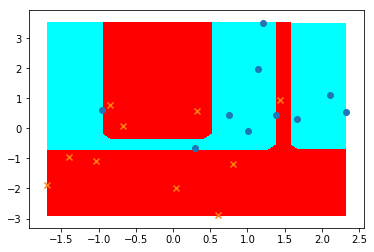

In [9]:
#the_set = ut.createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),10)

# un exemple d'utilisation:
ad=ArbreDecision(0.0)          # initialiation d'un arbre binaire qui utilisera epsilon= 0.0
ad.train(set_exemples)              # construction de l'arbre à partir de la base jouet
ut.plot_frontiere(set_exemples,ad,20)  # tracé graphique de la frontière de décision
ut.plot2DSet(set_exemples) 

## Etape 2: Bagging d'arbres de décision

### Tirage aléatoire d'exemples

Le bootstrap s'effectue en tirant aléatoirement un échantillon de $m$ exemples à partir de la base d'apprentissage $X$. Cet échantillon sert ensuite à construire un classifieur.

Dans l'algorithme du bagging, ce processus est répété $B$ fois.

Afin de ne pas alourdir la place mémoire nécessaire pour réaliser un tel tirage, on ne travaille que sur les indices des exemples dans la base. Un **échantillon de $X$ est donc un vecteur d'entiers** qui représentent les indices des exemples choisis.


#### Tirages aléatoires en Python

Consulter la librairie Python random qui propose différentes fonctions utiles pour implémenter le tirage aléatoire du bootstrap.

Par exemple, la fonction <code>sample()</code> de la librairie <code>random</code> rend une sélection aléatoire dans une population donnée en réalisant un tirage sans remise.

Pour tester, exécuter plusieurs fois les instructions de la boîte suivante :

In [10]:
import random
L= [i for i in range(0,11)]             # construction de la liste des entiers de 0 à 10
print("La liste L de départ: ",L)
EchL = random.sample(L,6)               # tirage de 6 éléments de L
print("Echantillon: ",EchL)

La liste L de départ:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Echantillon:  [9, 3, 6, 10, 5, 7]


La fonction <code>choice()</code> permet de choisir aléatoirement un élément:

In [11]:
L= [i for i in range(0,11)]             # construction de la liste des entiers de 0 à 10
print("La liste L de départ: ",L)
elt = random.choice(L)                  # choix d'un élémént
print("Element choisi: ",elt)

La liste L de départ:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Element choisi:  4


<font color="RED" size="+1">**[Q]**</font> Ecrire une fonction <code>tirage()</code> qui étant donné un vecteur d'entiers $VX$ qui représente l'ensemble des indices des exemples d'une base d'apprentissage $X$, un entier $m$, et un booléen $r$, rend un vecteur de $m$ indices choisis aléatoirement dans $VX$. Si le booléen $r$ est vrai, le tirage s'effectue *avec remise*, sinon il s'effectue *sans remise*.

In [12]:
def tirage(Vec_X, m, r):
    if r == True:
        res = []
        for i in range(m):
            res.append(random.choice(Vec_X))
        return res
    else:
        return random.sample(Vec_X,m)  

Exemples :

In [13]:
L= [i for i in range(0,10)]    # construction de la liste des entiers de 0 à 10
tirage(L,8,True)               # tirage avec remise

[7, 4, 8, 3, 8, 0, 6, 0]

In [14]:
tirage(L,8,False)               # tirage sans remise

[0, 5, 3, 9, 1, 6, 7, 8]

<font color="RED" size="+1">**[Q]**</font> En utilisant la fonction précédente, écrire la fonction <code>echantillonLS()</code> qui, étant donné un <code>LabeledSet</code> $X$, un nombre entier $m$, et un booléen rend un échantillon de $X$ de taille $m$ sous la forme d'un <code>LabeledSet</code>. L'échantillon est obtenu par un tirage avec remise si le booléen est True, sinon, il est obtenu sans remise.

In [15]:
def echantillonLS(LS_X, m, r):
    index = tirage([i for i in range (LS_X.size())], m, r)
    res = ls.LabeledSet(LS_X.getInputDimension())
    for ind in index:
        res.addExample(LS_X.getX(ind), LS_X.getY(ind))
    return res

In [16]:
#the_set.affiche_base()

the_set_echan = echantillonLS(set_exemples, 10, True)
the_set_echan.affiche_base()

Exemple 0
	description :  [1.13739407 1.96688274]
	label :  [1]
Exemple 1
	description :  [-0.84587452  0.76176619]
	label :  [-1]
Exemple 2
	description :  [0.31930177 0.56616978]
	label :  [-1]
Exemple 3
	description :  [-0.84587452  0.76176619]
	label :  [-1]
Exemple 4
	description :  [2.32319808 0.5365778 ]
	label :  [1]
Exemple 5
	description :  [-0.84587452  0.76176619]
	label :  [-1]
Exemple 6
	description :  [1.20583099 3.50817309]
	label :  [1]
Exemple 7
	description :  [1.6694259  0.31368798]
	label :  [1]
Exemple 8
	description :  [-0.67399801  0.06939319]
	label :  [-1]
Exemple 9
	description :  [0.74750978 0.42954491]
	label :  [1]


<font color="RED" size="+1">**[Q]**</font> Ecrire la classe <code>ClassifierBaggingTree</code>, dérivée de la classe <code>Classifier</code>, qui permet d'implémenter un bagging d'arbres de décision. Les spécifications de cette classe sont :
- la création de l'ensemble nécessite les paramètres suivants : 
    - le nombre $B$ d'arbres à construire, 
    - le pourcentage d'exemples de la base d'apprentissage utilisés pour constituer un échantillon, 
    - un booléen qui précise si un échantillon est tiré avec ou sans remise
    - et la valeur de seuil d'entropie pour arrêter la construction de chaque arbre, 
- l'apprentissage (méthode <code>train()</code>) construit autant d'arbres que précisé à la création. Chaque arbre est construit à partir d'un échantillon de la base d'apprentissage (<code>LabeledSet</code>) donnée en argument. Les arbres construits sont stockés dans un ensemble Python.
- la prédiction (méthode <code>predict()</code>) classe un exemple par vote de tous les arbres de la forêt. Si la somme des votes est positive ou nulle, la classe rendue est +1, sinon, la classe rendue est -1.

In [17]:
class ClassifierBaggingTree(cl.Classifier):
    """Arguments:
        - Le nombre B d'arbres à construire
        - Le pourcentage d'exemples de la base d'apprentissage utilisés pour constituer un échantillon
        - La valeur de seuil d'entropie pour arrêter la construction de chaque arbre
        - Un booléen qui précise si un échantillon est tiré avec ou sans remise
    """
    def __init__(self, B, pourc, seuil, r, maxLevel = None):
        self.nb_arbres = B
        self.pourcent = pourc
        self.seuil = seuil
        self.remise = r
        self.maxLevel = maxLevel
    
    def predict(self, x):
        """rend la prediction sur x (-1 ou +1)
        """
        res = 0
        for arbre in self.arbres:
            res += arbre.predict(x)
        if res >= 0:
            return 1
        return -1
        
    def train(self, labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        self.arbres = set()
        taille = int(labeledSet.size() * self.pourcent)
        for i in range(self.nb_arbres):
            temp_ls = echantillonLS(labeledSet, taille, self.remise)
            temp_ad= ArbreDecision(self.seuil, maxLevel = self.maxLevel)
            temp_ad.train(temp_ls)   
            self.arbres.add(temp_ad)

exemple: 0  vraie classe =  [1] - classe trouvee =  1
exemple: 1  vraie classe =  [1] - classe trouvee =  1
exemple: 2  vraie classe =  [1] - classe trouvee =  1
exemple: 3  vraie classe =  [1] - classe trouvee =  1
exemple: 4  vraie classe =  [1] - classe trouvee =  1
exemple: 5  vraie classe =  [1] - classe trouvee =  1
exemple: 6  vraie classe =  [1] - classe trouvee =  1
exemple: 7  vraie classe =  [1] - classe trouvee =  1
exemple: 8  vraie classe =  [1] - classe trouvee =  1
exemple: 9  vraie classe =  [1] - classe trouvee =  1
exemple: 10  vraie classe =  [-1] - classe trouvee =  1
exemple: 11  vraie classe =  [-1] - classe trouvee =  -1
exemple: 12  vraie classe =  [-1] - classe trouvee =  1
exemple: 13  vraie classe =  [-1] - classe trouvee =  -1
exemple: 14  vraie classe =  [-1] - classe trouvee =  1
exemple: 15  vraie classe =  [-1] - classe trouvee =  1
exemple: 16  vraie classe =  [-1] - classe trouvee =  -1
exemple: 17  vraie classe =  [-1] - classe trouvee =  1
exemple: 

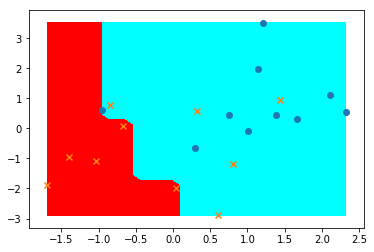

In [18]:
foret = ClassifierBaggingTree(10,0.3,0.0,True)
foret.train(set_exemples)
for i in range(set_exemples.size()):
    print("exemple:",i," vraie classe = ", set_exemples.getY(i), "- classe trouvee = ", foret.predict(set_exemples.getX(i)))
    
ut.plot_frontiere(set_exemples,foret,20)
ut.plot2DSet(set_exemples) 

print("\naccuracy totale:",foret.accuracy(set_exemples))

### Expérimentations

<font color="RED" size="+1">**[Q]**</font> Expérimenter l'algorithme précédent de la façon suivante :
- générer une base d'apprentissage $X$ contenant au moins 1000 exemples ;
- réaliser un échantillon de cette base contenant 50 exemples de chaque classe. Soit $E$ cet échantillon, et soit $F$ l'ensemble des exemples de $X$ qui ne sont pas dans $E$ ;
- réaliser un apprentissage par bagging sur $F$ et évaluer le taux de prédiction du modèle obtenu sur $E$ ;
- construire la courbe donnant le taux de prédiction obtenu en augmentant la taille de la forêt d'arbres de 1 à 20 arbres. 

In [19]:
X = ut.createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),1000)

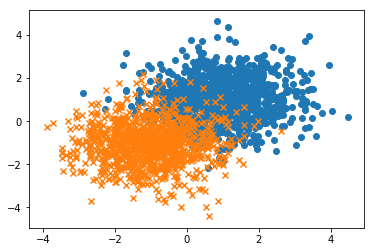

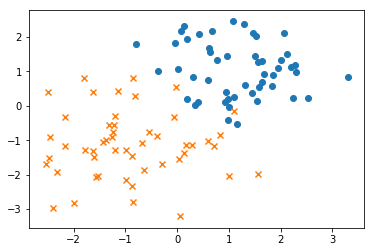

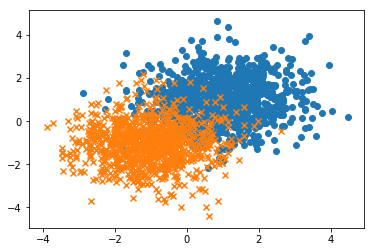

In [20]:
def subSetClasse(labeledSet):
    """
    Separe le LabeledSet pris en argument en deux, suivant les classes 1 et -1.
    """
    res_plus = ls.LabeledSet(labeledSet.getInputDimension())
    res_moins = ls.LabeledSet(labeledSet.getInputDimension())
    for i in range(labeledSet.size()):
        if labeledSet.getY(i) == 1:
            res_plus.addExample(labeledSet.getX(i), 1)
        else:
            res_moins.addExample(labeledSet.getX(i), -1)   
    return res_plus, res_moins

def subSetClasseAmeliore(labeledSet):
    """
    Separe le LabeledSet pris en argument en deux, suivant les classes 1 et -1.
    Utilise des vues des tabelaux X et Y du labeledSet.
    """
    res_plus = ls.LabeledSet(labeledSet.getInputDimension())
    res_moins = ls.LabeledSet(labeledSet.getInputDimension())
    ind_plus = np.where(labeledSet.y == 1)[0]
    ind_moins = np.where(labeledSet.y == -1)[0]
    res_plus.x = labeledSet.x[ind_plus, :]
    res_plus.y = labeledSet.y[ind_plus, :]
    res_moins.x = labeledSet.x[ind_moins, :]
    res_moins.y = labeledSet.y[ind_moins, :]
    res_plus.nb_examples = ind_plus.size
    res_moins.nb_examples = ind_moins.size
    return res_plus, res_moins
    
def fusionSet(LS1, LS2):
    """
    Fusionne les deux LabeledSet LS1 et LS2.
    Les deux doivent avoir le même InputDimension.    
    """
    res = ls.LabeledSet(LS1.getInputDimension())
    for i in range(LS1.size()):
        res.addExample(LS1.getX(i), LS1.getY(i)) 
    for i in range(LS2.size()):
        res.addExample(LS2.getX(i), LS2.getY(i))
    return res

def fusionSetAmeliore(LS1, LS2):
    """
    Fusionne les deux LabeledSet LS1 et LS2.
    Les deux doivent avoir le même InputDimension.    
    """
    res = ls.LabeledSet(LS1.getInputDimension())
    res.x = np.empty((LS1.size() + LS2.size(), LS1.getInputDimension()), dtype = LS1.x.dtype)
    res.y = np.empty((LS1.size() + LS2.size(), 1), dtype = LS1.y.dtype)
    res.nb_examples = res.x.shape[0]
    res.x[:LS1.size(), :] = LS1.x
    res.x[LS1.size():, :] = LS2.x
    res.y[:LS1.size(), :] = LS1.y
    res.y[LS1.size():, :] = LS2.y
    return res

def subSet(labeledSet, x, y):
    """
    Separe le LabeledSet passé en argument en deux :
    - Le premier avec les données entre les indices x et y du LabeledSet original
    - Le deuxième avec les autres données.
    L'indice x est inclus et y est exclu.
    """
    res_xy = ls.LabeledSet(labeledSet.getInputDimension())
    res = ls.LabeledSet(labeledSet.getInputDimension())
    for i in range (labeledSet.size()):
        if i >= x and i < y:
            res_xy.addExample(labeledSet.getX(i), labeledSet.getY(i))
        else:
            res.addExample(labeledSet.getX(i), labeledSet.getY(i))
    return res_xy, res

def subSetAmeliore(labeledSet, x, y):
    """
    Separe le LabeledSet passé en argument en deux :
    - Le premier avec les données entre les indices x et y du LabeledSet original
    - Le deuxième avec les autres données.
    L'indice x est inclus et y est exclu.
    """
    res_xy = ls.LabeledSet(labeledSet.getInputDimension())
    res = ls.LabeledSet(labeledSet.getInputDimension())
    res_xy.x = labeledSet.x[x:y, :]
    res_xy.y = labeledSet.y[x:y, :]
    res.x = np.concatenate((labeledSet.x[:x, :], labeledSet.x[y:, :]))
    res.y = np.concatenate((labeledSet.y[:x, :], labeledSet.y[y:, :]))
    res_xy.nb_examples = res_xy.x.shape[0]
    res.nb_examples = res.x.shape[0]
    return res_xy, res

x_plus, x_moins = subSetClasseAmeliore(X)

e1, f1 = subSetAmeliore(x_plus, 0, 50)
e2, f2 = subSetAmeliore(x_moins, 0, 50)
E = fusionSetAmeliore(e1, e2)
F = fusionSetAmeliore(f1, f2)

fig, ax = plt.subplots()
ut.plot2DSet(X) 

fig, ax = plt.subplots()
ut.plot2DSet(E)

fig, ax = plt.subplots()
ut.plot2DSet(F)


In [21]:
# Réaliser un apprentissage par bagging sur F et évaluer le taux de prédiction du modèle sur E
foret20 =  ClassifierBaggingTree(20,0.3,0.0,True)
foret20.train(F)
print("Bagging : 20 trees: accuracy totale: train=%.4f test=%.4f"%(foret20.accuracy(F),foret20.accuracy(E)))

Bagging : 20 trees: accuracy totale: train=94.3684 test=96.0000


In [22]:
moys_tab_train = np.zeros(21)
moys_tab_test = np.zeros(21)

for quant_arbres in range(1, 21):
    x_plus, x_moins = subSetClasseAmeliore(X)
    cpt = 0
    x = 0
    y = 50
    taux_apren_train = 0
    taux_apren_test = 0
    while y < x_plus.size():        
        e1, f1 = subSetAmeliore(x_plus, x, y)
        e2, f2 = subSetAmeliore(x_moins, x, y)
        E = fusionSetAmeliore(e1, e2)
        F = fusionSetAmeliore(f1, f2)
        
        foret = ClassifierBaggingTree(quant_arbres,0.3,0.0,True)
        foret.train(F)
        taux_apren_train += foret.accuracy(F)
        taux_apren_test += foret.accuracy(E)
        
        cpt+= 1
        x+= 50
        y+= 50
    
    moys_tab_train[quant_arbres] = taux_apren_train/cpt
    moys_tab_test[quant_arbres] = taux_apren_test/cpt

moys_tab_train = moys_tab_train[1:]
moys_tab_test = moys_tab_test[1:]
    
print (moys_tab_train)
print (moys_tab_test)

[91.51800554 91.79501385 93.49307479 93.44598338 94.04155125 94.13573407
 94.27146814 94.27700831 94.47645429 94.47091413 94.64265928 94.66204986
 94.71191136 94.73407202 94.6398892  94.65096953 94.73684211 94.73684211
 94.75623269 94.69529086]
[88.63157895 88.84210526 90.31578947 91.05263158 90.73684211 91.
 91.68421053 91.31578947 91.84210526 91.10526316 90.47368421 91.
 90.89473684 91.84210526 91.31578947 92.         92.10526316 92.10526316
 91.36842105 91.84210526]


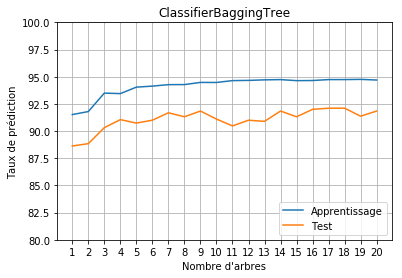

In [23]:
fig, ax = plt.subplots()
ax.grid(True)
ax.set_title("ClassifierBaggingTree")
ax.set_xlabel("Nombre d'arbres")
ax.set_ylabel("Taux de prédiction")
ax.set_xticks(range(1, 21))
ax.set_ylim((80, 100))
ax.plot(range(1, 21), moys_tab_train, label = 'Apprentissage') 
ax.plot(range(1, 21), moys_tab_test, label = 'Test')
ax.legend(loc="lower right");

On remarque que le taux de prédiction est déjà assez bon avec un seul arbre, mais augmente avec le nombre de arbres utilisés, se stabilisant autour de 10 arbres.

### Evaluation par la méthode "Out Of Bags"

<font color="RED" size="+1">**[Q]**</font> Sur les mêmes données, réaliser une évaluation par la méthode "Out Of Bags" vue en cours. Construire la courbe donnant le taux de prédiction OOB en fonction de la taille de la forêt d'arbres.

Pour cela, écrire la classe <code>ClassifierBaggingTreeOOB</code> qui étend la classe d'un classifieur bagging pour prendre en compte la spécificité de l'approche OOB.
Ainsi, à partir de $\mathcal{X}$, l'ensemble des données d'apprentissage, chaque arbre $A_i$ de la forêt est associé à 2 sous-ensembles de $\mathcal{X}$: 
- $\mathcal{X}_i$: l'échantillon bootstrap qui sert à construire l'arbre $A_i$
- $\mathcal{T}_i$: l'ensemble des exemples OOB associés à l'arbre $A_i$

Le calcul du taux de bonne classification s'effectuera comme suit:
- soit $t_i$ le taux de bonne classification de $A_i$ pour l'ensemble OOB $\mathcal{T}_i$
- le taux de global de bonne classification de la forêt d'arbres $A_1$,..., $A_B$ est donné par $\frac{1}{B}\sum_{i=1}^{B} t_i$


In [24]:
def echantillonDepuisIndices(LS_X, listIndices):
    #index = tirage([i for i in range (LS_X.size())], m, r)
    res = ls.LabeledSet(LS_X.getInputDimension())
    for ind in listIndices:
        res.addExample(LS_X.getX(ind), LS_X.getY(ind))
    return res

class ClassifierBaggingTreeOOB(ClassifierBaggingTree):
    """Arguments:
        - Le nombre B d'arbres à construire
        - Le pourcentage d'exemples de la base d'apprentissage utilisés pour constituer un échantillon
        - La valeur de seuil d'entropie pour arrêter la construction de chaque arbre
        - Un booléen qui précise si un échantillon est tiré avec ou sans remise
    """
        
    def train(self, labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        self.arbres = dict()
        
        taille = int(labeledSet.size() * self.pourcent)
        for i in range(self.nb_arbres):
            index = tirage([i for i in range (labeledSet.size())], taille, self.remise)
            temp_ls = echantillonDepuisIndices(labeledSet, index)
            temp_ad = ArbreDecision(self.seuil, maxLevel = self.maxLevel)
            temp_ad.train(temp_ls)   
            self.arbres[temp_ad] = index
            
    def accuracyOOB(self, labeledSet):
        """
        Accuracy par la méthode OOB. Il faut que labeledSet soit le même utilisé dans train.
        """
        tBar = 0
        for arbre in self.arbres:
            index = self.arbres[arbre]
            ti = 0
            Ti = np.setdiff1d(np.arange(labeledSet.size()), index)
            for i in Ti:
                if self.predict(labeledSet.getX(i)) == labeledSet.getY(i):
                    ti += 1
            ti /= Ti.size
            tBar += ti
        tBar /= self.nb_arbres
        return tBar*100
        

In [25]:
# Réaliser un apprentissage par bagging sur X et évalue le taux de prédiction du modèle par la méthode Out of bagging.
classifierOOB20 =  ClassifierBaggingTreeOOB(20,0.3,0.0,True)
classifierOOB20.train(X)
print("Bagging : 20 trees: taux de prédiction par OOB: %.4f"%(classifierOOB20.accuracyOOB(X)))

Bagging : 20 trees: taux de prédiction par OOB: 94.2900


## Etape 3: Random forests

<font color="RED" size="+1">**[Q]**</font> Ecrire et tester la classe <code>ClassifierRandomForest</code> qui implémente l'algorithme des random forests vu en cours.

Pour cela, vous devrez:
- définir une méthode <code>construit_AD_aleatoire(LSet,epsilon,nbatt)</code> qui utilise $nbatt$ attributs choisis aléatoirement à chaque niveau de la construction de l'arbre
- définir une nouvelle classe <code>ArbreDecisionAleatoire</code> qui étend la classe <code>ArbreDecision</code> en surchargeant la méthode <code>train</code>. Le constructeur d'un tel arbre prendra en argument le nombre d'attributs à utiliser lors de la construction de l'arbre.

In [26]:
def construit_AD_aleatoire(LSet, epsilon, nbatt):
    """ LSet : LabeledSet
        epsilon : seuil d'entropie pour le critère d'arrêt 
        nbatt : nombre d'attributs choisis à chaque niveau de la construction. Il faut que nbatt << LSet.getInputDimension().
    """
    if entropie(LSet) <= epsilon:
        feuille = ArbreBinaire()
        feuille.ajoute_feuille(classe_majoritaire(LSet))
        return feuille
    taille = LSet.getInputDimension()
    entro = 1.1     
    seuil = None
    att = None
    cols = tirage(range(taille), nbatt, False)
    for col in cols: 
        se_test, ent_test = discretise2(LSet, col)
        if entro > ent_test:
            att = col
            entro = ent_test
            seuil = se_test
    if (entropie(LSet) - entro) <= epsilon:
        feuille = ArbreBinaire()
        feuille.ajoute_feuille(classe_majoritaire(LSet))
        return feuille
    noeud = ArbreBinaire()
    LSGauche, LSDroite = divise(LSet, att, seuil)   
    ADGauche = construit_AD_aleatoire(LSGauche, epsilon, nbatt)
    ADDroite = construit_AD_aleatoire(LSDroite, epsilon, nbatt)
    noeud.ajoute_fils(ADGauche, ADDroite, att, seuil)
    return noeud

In [27]:
class ArbreDecisionAleatoire(ArbreDecision):
    # Constructeur
    def __init__(self,epsilon,nbatt):
        super(ArbreDecisionAleatoire, self).__init__(epsilon)
        self.nbatt = nbatt
    
    # Permet d'entrainer le modele sur un ensemble de données
    def train(self,set):
        # construction de l'arbre de décision 
        self.set=set
        self.racine = construit_AD_aleatoire(set,self.epsilon, self.nbatt)

On teste la classe `ArbreDecisionAleatoire` :

In [28]:
X = ut.createGaussianDataset(np.ones(10),np.eye(10),-np.ones(10),np.eye(10),1000)
X.input_dimension = 10

arbre = ArbreDecision(0.0)
arbreAlea = ArbreDecisionAleatoire(0.0, 5)

arbre.train(X)
arbreAlea.train(X)

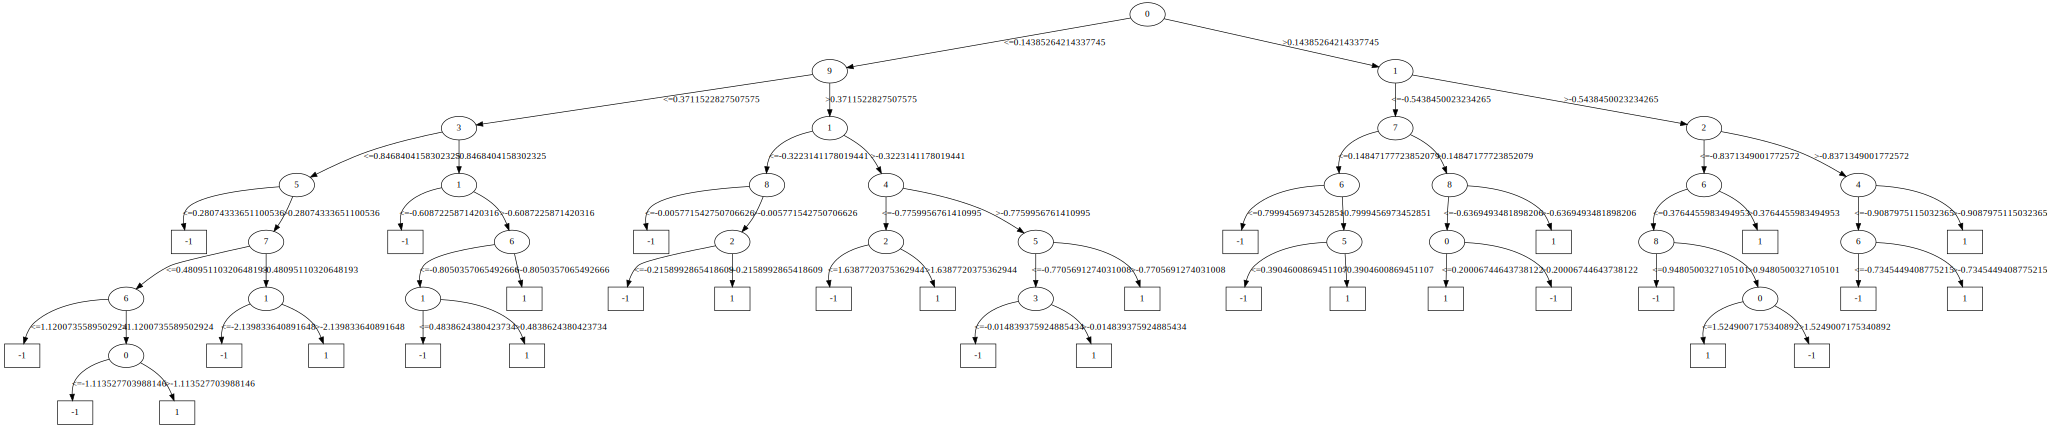

In [29]:
arbre.plot()

On construit maintenant la classe ClassifierRandomForest :

In [30]:
class ClassifierRandomForest(ClassifierBaggingTree):
    """Arguments:
        - Le nombre B d'arbres à construire
        - Le pourcentage d'exemples de la base d'apprentissage utilisés pour constituer un échantillon
        - La valeur de seuil d'entropie pour arrêter la construction de chaque arbre
        - Un booléen qui précise si un échantillon est tiré avec ou sans remise
        - Le nombre de colonnes nbatt à utiliser à chaque niveau de l'arbre.
    """
    def __init__(self, B, pourc, seuil, r, nbatt):
        super(ClassifierRandomForest, self).__init__(B, pourc, seuil, r)
        self.nbatt = nbatt
    
    def train(self, labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        self.arbres = set()
        taille = int(labeledSet.size() * self.pourcent)
        for i in range(self.nb_arbres):
            temp_ls = echantillonLS(labeledSet, taille, self.remise)
            temp_ad= ArbreDecisionAleatoire(self.seuil, self.nbatt)
            temp_ad.train(temp_ls)
            self.arbres.add(temp_ad)

In [31]:
moys_tab_train = np.zeros(21)
moys_tab_test = np.zeros(21)

for quant_arbres in range(1, 21):
    x_plus, x_moins = subSetClasseAmeliore(X)
    cpt = 0
    x = 0
    y = 50
    taux_apren_train = 0
    taux_apren_test = 0
    while y < x_plus.size():        
        e1, f1 = subSetAmeliore(x_plus, x, y)
        e2, f2 = subSetAmeliore(x_moins, x, y)
        E = fusionSetAmeliore(e1, e2)
        F = fusionSetAmeliore(f1, f2)
        
        foret = ClassifierRandomForest(quant_arbres,0.3,0.0,True, 1)
        foret.train(F)
        taux_apren_train += foret.accuracy(F)
        taux_apren_test += foret.accuracy(E)
        
        cpt+= 1
        x+= 50
        y+= 50
    
    moys_tab_train[quant_arbres] = taux_apren_train/cpt
    moys_tab_test[quant_arbres] = taux_apren_test/cpt

moys_tab_train = moys_tab_train[1:]
moys_tab_test = moys_tab_test[1:]
    
print (moys_tab_train)
print (moys_tab_test)

[96.20775623 96.38781163 98.81163435 98.95567867 99.49584488 99.41828255
 99.63434903 99.70083102 99.77285319 99.8199446  99.85872576 99.88088643
 99.86426593 99.90304709 99.90304709 99.90581717 99.92243767 99.90858726
 99.92520776 99.93351801]
[95.15789474 94.36842105 98.05263158 98.52631579 98.73684211 98.89473684
 99.21052632 99.05263158 99.52631579 99.47368421 99.47368421 99.42105263
 99.57894737 99.36842105 99.78947368 99.63157895 99.68421053 99.73684211
 99.68421053 99.68421053]


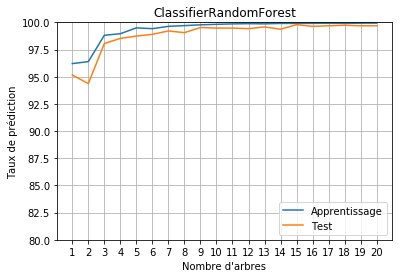

In [32]:
fig, ax = plt.subplots()
ax.grid(True)
ax.set_title("ClassifierRandomForest")
ax.set_xlabel("Nombre d'arbres")
ax.set_ylabel("Taux de prédiction")
ax.set_xticks(range(1, 21))
ax.set_ylim((80, 100))
ax.plot(range(1, 21), moys_tab_train, label = 'Apprentissage') 
ax.plot(range(1, 21), moys_tab_test, label = 'Test')
ax.legend(loc="lower right");

On fait maintenant une version du ClassifierRandomForest avec évaluation par la méthode "Out Of Bags" :

In [33]:
class ClassifierRandomForestOOB(ClassifierRandomForest):
    """Arguments:
        - Le nombre B d'arbres à construire
        - Le pourcentage d'exemples de la base d'apprentissage utilisés pour constituer un échantillon
        - La valeur de seuil d'entropie pour arrêter la construction de chaque arbre
        - Un booléen qui précise si un échantillon est tiré avec ou sans remise
        - Le nombre de colonnes nbatt à utiliser à chaque niveau de l'arbre.
    """
 
    def train(self, labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        self.arbres = dict()
        taille = int(labeledSet.size() * self.pourcent)
        for i in range(self.nb_arbres):
            index = tirage([i for i in range (labeledSet.size())], taille, self.remise)
            temp_ls = echantillonDepuisIndices(labeledSet, index)
            temp_ad= ArbreDecisionAleatoire(self.seuil, self.nbatt)
            temp_ad.train(temp_ls)
            self.arbres[temp_ad] = index
            
    def accuracyOOB(self, labeledSet):
        """
        Accuracy par la méthode OOB. Il faut que labeledSet soit le même utilisé dans train.
        """
        tBar = 0
        for arbre in self.arbres:
            index = self.arbres[arbre]
            ti = 0
            Ti = np.setdiff1d(np.arange(labeledSet.size()), index)
            for i in Ti:
                if self.predict(labeledSet.getX(i)) == labeledSet.getY(i):
                    ti += 1
            ti /= Ti.size
            tBar += ti
        tBar /= self.nb_arbres
        return tBar*100

In [34]:
# Réaliser un apprentissage par bagging sur X et évalue le taux de prédiction du modèle par la méthode Out of bagging.
classifierOOB20 =  ClassifierRandomForestOOB(20,0.3,0.0,True, 3)
classifierOOB20.train(X)
print("Bagging : 20 trees: taux de prédiction par OOB: %.4f"%(classifierOOB20.accuracyOOB(X)))

Bagging : 20 trees: taux de prédiction par OOB: 99.7637


## Etape 4: expérimentation

<font color="RED" size="+1">**[Q]**</font> Comparer le bagging d'arbres et les random forests sur d'autres bases d'apprentissage (réelles ou générées aléatoirement). Construire la courbe donnant le taux de prédiction pour une forêt d'arbres variant de 1 à 100 arbres (cela peut prendre du temps, tester sur un nombre réduit d'arbres dans un premier temps).

On utilise la base de données du TME 3 (https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Coimbra).

In [35]:
cancer_pd = pd.read_csv("data/dataR2.csv")
cancer_pd = (cancer_pd - cancer_pd.mean())/cancer_pd.std() # Normalisation

# Construction du LabeledSet
cancer_test = ls.LabeledSet(len(cancer_pd.columns) - 1)
res = 0
for i, r, in cancer_pd.iterrows():
    if r["Classification"] < 0:
        res = -1
    else:
        res = 1
    cancer_test.addExample(r.values[:-1],res)   # ajout des vecteurs du dataset

cancer_test.affiche_base()

Exemple 0
	description :  [-0.57728911 -0.8131475  -1.23386921 -0.72559146 -0.61162891 -0.92830669
 -0.06991818 -0.54316103 -0.33977652]
	label :  [-1]
Exemple 1
	description :  [ 1.59490162 -1.3727948  -0.25718366 -0.68506609 -0.54587223 -0.92639356
 -0.69433755 -0.86048105 -0.19039777]
	label :  [-1]
Exemple 2
	description :  [ 1.53283902 -0.88791233 -0.30157845 -0.54769701 -0.46274479 -0.45225706
  1.79023159 -0.43975237  0.05796261]
	label :  [-1]
Exemple 3
	description :  [ 0.66396273 -1.23793255 -0.92310563 -0.67404081 -0.57172925 -0.87223707
 -0.44003562 -0.15818109  1.13778142]
	label :  [-1]
Exemple 4
	description :  [ 1.78108939 -1.28900891 -0.25718366 -0.64195822 -0.51882997 -1.03817833
 -0.78348187 -0.33489908  0.69171506]
	label :  [-1]
Exemple 5
	description :  [-0.51522652 -0.9417381  -0.25718366 -0.67404081 -0.53895589 -1.0312817
  0.51128181 -0.35578177 -0.01224876]
	label :  [-1]
Exemple 6
	description :  [ 1.96727717 -0.97250574 -0.92310563 -0.52862625 -0.49538134 -1

In [36]:
nb_arbres_max = 100
nb_folds = 5

# Niveau de récursion maximal pour les arbres de décision
nb_maxLevel = None

#nombre de colonnes pur le ClassifierRandomForest
nb_colonnes = 4

#seuil d'entropie
epsilon = 0.1

tauxBaggingTree = np.zeros(nb_arbres_max)
tauxBaggingTreeOOB = np.zeros(nb_arbres_max)
tauxRandomForest = np.zeros(nb_arbres_max)
tauxRandomForestOOB = np.zeros(nb_arbres_max)

for nb_arbres in range(1, nb_arbres_max + 1):
    #print("nb_arbres =", nb_arbres)
    
    x_plus, x_moins = subSetClasse(cancer_test)
    
    qt_plus = x_plus.size()//nb_folds
    qt_moins = x_moins.size()//nb_folds
    reste_plus = x_plus.size()%nb_folds
    reste_moins = x_moins.size()%nb_folds
    
    i_plus = 0
    i_moins = 0
    j_plus = qt_plus
    j_moins = qt_moins

    if reste_plus > 0:
        j_plus += 1
        reste_plus -= 1
    
    if reste_moins > 0:
        j_moins += 1
        reste_moins -= 1
 
    for folds in range(nb_folds):
        #print("nb_folds =",nb_folds)
        e1, f1 = subSet(x_plus, i_plus, j_plus)
        e2, f2 = subSet(x_moins, i_moins, j_moins)
        E = fusionSet(e1, e2)
        F = fusionSet(f1, f2)
        
        baggingTree = ClassifierBaggingTree(nb_arbres,0.3,epsilon,True, maxLevel = nb_maxLevel)
        randomForest = ClassifierRandomForest(nb_arbres,0.3,epsilon,True, nb_colonnes)
        
        baggingTree.train(F)
        randomForest.train(F)
        
        tauxBaggingTree[nb_arbres - 1] += baggingTree.accuracy(E)
        tauxRandomForest[nb_arbres - 1] += randomForest.accuracy(E)
        
        i_plus = j_plus
        i_moins = j_moins
        
        j_plus += qt_plus
        j_moins += qt_moins

        if reste_plus > 0:
            j_plus += 1
            reste_plus -= 1

        if reste_moins > 0:
            j_moins += 1
            reste_moins -= 1
        
    tauxBaggingTree[nb_arbres - 1] /= nb_folds
    tauxRandomForest[nb_arbres - 1] /= nb_folds

    baggingTreeOOB = ClassifierBaggingTreeOOB(nb_arbres,0.3,epsilon,True, maxLevel = nb_maxLevel)
    baggingTreeOOB.train(cancer_test)
    randomForestOOB = ClassifierRandomForestOOB(nb_arbres,0.3,epsilon,True, nb_colonnes)
    randomForestOOB.train(cancer_test)
    
    tauxBaggingTreeOOB[nb_arbres - 1] = baggingTreeOOB.accuracyOOB(cancer_test)
    tauxRandomForestOOB[nb_arbres - 1] = randomForestOOB.accuracyOOB(cancer_test)

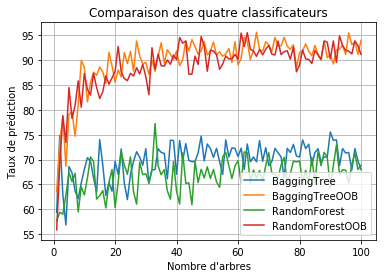

In [37]:
fig, ax = plt.subplots()
ax.grid(True)
ax.set_title("Comparaison des quatre classificateurs")
ax.set_xlabel("Nombre d'arbres")
ax.set_ylabel("Taux de prédiction")
#ax.set_xticks(range(1, nb_arbres_max + 1))
#ax.set_ylim((80, 100))
ax.plot(range(1, nb_arbres_max + 1), tauxBaggingTree, label = 'BaggingTree') 
ax.plot(range(1, nb_arbres_max + 1), tauxBaggingTreeOOB, label = 'BaggingTreeOOB')
ax.plot(range(1, nb_arbres_max + 1), tauxRandomForest, label = 'RandomForest') 
ax.plot(range(1, nb_arbres_max + 1), tauxRandomForestOOB, label = 'RandomForestOOB') 
ax.legend(loc="lower right");

## Exercices à faire chez vous (sur papier)

Pour vous entraîner sans machine... *(exercice de l'examen 2017)*

Soit $V=\{v_{1}, v_{2},..., v_{n}\}$ un ensemble de $n$ valeurs réelles ordonnées,
  telles que $v_1 \geq v_2 \geq \ldots \geq v_{n}$.. On note $\bar{v}$ la valeur moyenne de $V$. La variance de $V$, $var(V)$ est définie par:
$var(V) = \frac{1}{n} \sum_{i=1}^{n} (v_{i} - \bar{v})^2$. 

Et soit $W=\{w_{1}, w_{2},..., w_{n}\}$ tel que,pour tout $i=1,...,n$.


** [Q] ** Donner l'expression de $\bar{v}$ en fonction des valeurs de $V$.

** [Q] **  Montrer que $var(aV+b) = a^2 var(V)$.

** [Q] ** Donner l'expression de $V\cdot W$ (le produit scalaire) en fonction des coordonnées
   de $V$ et de $W$.
   
** [Q] ** Comment doit-on définir $W$ si on souhaite que $V\cdot W = \bar{v}$ ?


** [Q] ** Comment doit-on définir $W$ si on souhaite que
   $V\cdot W = \displaystyle\max_{i=1,...n} v_i$ ? Même question si on souhaite que
   $V\cdot W = \displaystyle\min_{i=1,...n} v_i$ ?

** [Q] ** Soit un entier $k$ tel que $0<k\leq n$. Proposer une définition de $W$ qui, par le
   calcul du produit scalaire, permet de ne tenir compte, de façon équitable, que des $k$
   valeurs les plus élevées de $V$.



Réponses :

1. $$\overline v = \frac{1}{n} \sum_{i=1}^n v_i$$

2. On a :
$$
\begin{aligned}
\overline{av + b} & = \frac{1}{n}\sum_{i=1}^n (a v_i + b) \\
& = \frac{1}{n}\left(\sum_{i=1}^n a v_i + \sum_{i=1}^n b\right) \\
& = \frac{1}{n}\left(a\sum_{i=1}^n  v_i + n b\right) \\
& = \frac{a}{n}\sum_{i=1}^n  v_i + b \\
& = a\overline v + b
\end{aligned}
$$
Donc :
$$
\begin{aligned}
\text{Var}(aV + b) & = \frac{1}{n}\sum_{i=1}^n \left(a v_i + b - (\overline{av + b})\right)^2 \\
& = \frac{1}{n}\sum_{i=1}^n \left(a v_i + b - (a\overline v + b)\right)^2 \\
& = \frac{1}{n}\sum_{i=1}^n \left(a v_i - a\overline v\right)^2 \\
& = \frac{1}{n}\sum_{i=1}^n \left(a(v_i - \overline v)\right)^2 \\
& = \frac{1}{n}\sum_{i=1}^n \left(a^2(v_i - \overline v)^2\right) \\
& = \frac{a^2}{n}\sum_{i=1}^n \left(v_i - \overline v\right)^2 \\
& = a^2\text{Var}(V)
\end{aligned}
$$

3. $$V\cdot W = \sum_{i=1}^n v_iw_i$$

4. Il suffit de choisir $w_i = \frac{1}{n}$ pour tout $i$.

5. Pour le max, on choisit $w_i = 0$ pour tout $i$ sauf pour l'indice $i^*$ où $V$ atteint son max où $w_{i^*} = 1$. De même pour le min. 

6. Comme pour les calculs de max et min, les valeurs de $w_i$ sont égales a $0$ pour tout les indices sauf pour les indices correspondants aux $k$ valeurs plus élevées de $V$ où on choisit $w_i = 1$.